In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats
from numba import njit

import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [2]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Checking for nan
print(factor_ret_m.isna().sum().sum(), volatility.isna().sum().sum())

0 0


# Volatility timing

We will now do volatility timing of the factors. We will do almost the same thing as in `20_volatility_managed_factors.ipynb`, but we will use volatility and not variance. We will first use the market variance to time all factors, and then use the individual factors volatility.

$$r_{k,t+1}^\sigma=\frac{c}{\sigma_{k,t}} r_{k,t+1} \quad \text{ or } \quad r_{k,t+1}^\sigma=\frac{c}{\sigma_{m,t}} $$

In [3]:
### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

    def obj_func(c):
        vol_timed = (c / volatility['MKT']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Looking at c
print(c)

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
r_sigma_k_is, r_sigma_m_is = r_sigma_k.copy(), r_sigma_m.copy()

# for factor in factor_ret_m.columns:
#     r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
#     r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['MKT']).shift(1) * factor_ret_m[factor]
#     r_sigma_k_is[factor] = (c.loc['c_fac', factor] / volatility[factor]) * factor_ret_m[factor]
#     r_sigma_m_is[factor] = (c.loc['c_mkt', factor] / volatility['MKT']) * factor_ret_m[factor]

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (1 / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (1 / volatility['MKT']).shift(1) * factor_ret_m[factor]
    r_sigma_k_is[factor] = (1 / volatility[factor]) * factor_ret_m[factor]
    r_sigma_m_is[factor] = (1 / volatility['MKT']) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r_sigma_k_is = r_sigma_k_is.loc[r_sigma_k.index]
r_sigma_m_is = r_sigma_m_is.loc[r_sigma_m.index]
r = factor_ret_m.iloc[1:,]

         MKT    SMB    HML    UMD    BAB
c_fac 0.1546 0.1414 0.1507 0.1646 0.1892
c_mkt 0.1546 0.1690 0.1710 0.1474 0.1472


*Note:* The value of $c$ for $MKT$ is equal in both scenarios, and the reutrns will also be identical by construction.

# Mean-variance optimazation

We will now use a expanding window approch, where we start with a window of 120 months to pick weights for three portfolios. The three portfolios are:

 - Uncondtional Mean-Variance portfolio (UMV): The mean-variance portfolio for a invstor only investing in the orginal factors.
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{f}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on it's own past volatility, version of the factor. 
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{m}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on the market's past volatility, version of the factor. 

In [4]:
### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m', 'UMV^s', 'CMV_k^s', 'CMV_m^s']], index=r.index).iloc[window:,]

### Place to store the loadings
loading_umv = pd.DataFrame(index=MV.index, columns=r.columns)
loading_cmv_m = loading_umv.copy()
loading_cmv_k = loading_umv.copy()
loading_umv_s = loading_umv.copy()
loading_cmv_m_s = loading_umv.copy()
loading_cmv_k_s = loading_umv.copy()

### Place to store $a_k$ and $a_k$
a_cmv_m = pd.DataFrame(index=MV.index, columns=r.columns)
a_cmv_k = pd.DataFrame(index=MV.index, columns=r.columns)
a_cmv_m_s = pd.DataFrame(index=MV.index, columns=r.columns)
a_cmv_k_s = pd.DataFrame(index=MV.index, columns=r.columns)
b_cmv_m = pd.DataFrame(index=MV.index, columns=r.columns)
b_cmv_k = pd.DataFrame(index=MV.index, columns=r.columns)
b_cmv_m_s = pd.DataFrame(index=MV.index, columns=r.columns)
b_cmv_k_s = pd.DataFrame(index=MV.index, columns=r.columns)

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

data_m_is = pd.concat([r, r_sigma_m_is], axis=1)
data_k_is = pd.concat([r, r_sigma_k_is], axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_o_s = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
    w_m_s = ptf_weights(data_m_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
    w_k_s = ptf_weights(data_k_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)

    ## Saving the loadings
    loading_umv.iloc[i-window, :] = w_o
    loading_cmv_m.iloc[i-window, :] = w_m[0:5] + (w_m[5:10] * (1  / volatility['MKT'].loc['1993-02':][i-window]))
    loading_cmv_k.iloc[i-window, :] = w_k[0:5] + (w_k[5:10] * (1  / volatility.iloc[i]))
    loading_umv_s.iloc[i-window, :] = w_o_s
    loading_cmv_m_s.iloc[i-window, :] = w_m_s[0:5] + (w_m_s[5:10] * (1  / volatility['MKT'].loc['1993-02':][i-window]))
    loading_cmv_k_s.iloc[i-window, :] = w_k_s[0:5] + (w_k_s[5:10] * (1  / volatility.iloc[i]))

    ## Saving a and b
    a_cmv_m.iloc[i-window, :] = w_m[0:5]
    a_cmv_k.iloc[i-window, :] = w_k[0:5]
    a_cmv_m_s.iloc[i-window, :] = w_m_s[0:5]
    a_cmv_k_s.iloc[i-window, :] = w_k_s[0:5]
    b_cmv_m.iloc[i-window, :] = w_m[5:10]
    b_cmv_k.iloc[i-window, :] = w_k[5:10]
    b_cmv_m_s.iloc[i-window, :] = w_m_s[5:10]
    b_cmv_k_s.iloc[i-window, :] = w_k_s[5:10]

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_m * data_m.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_k * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'UMV^s'] = (w_o_s * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m^s'] = (w_m_s * data_m.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k^s'] = (w_k_s * data_k.iloc[i,]).sum()

sharpes_ratio(MV)

UMV       1.6386
CMV_k     1.6232
CMV_m     1.8047
UMV^s     1.6235
CMV_k^s   1.6273
CMV_m^s   1.8518
dtype: object

In [5]:
### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['P-value'])

### Number of simulations
n_boot = 100000

### Getting the data we need

### Loop for shrinkage or not
for s in [0,1]:

    ### Loop for factor or market
    for f in [1, 2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(MV.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(MV))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[:,f+s*3] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Looking at the p-values
p_values

,UMV,CMV_k,CMV_m,UMV^s,CMV_k^s,CMV_m^s
P-value,NaN,0.5624,0.1293,NaN,0.4654,0.0300


Now we will get the alphas running the following regression

$$CMV = \alpha + \beta \times UMV + \epsilon$$

In [6]:
### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']
print(f'Annualized alpha using factor volatility: {alpha_k*12:.3f}, t-stat: {tstat_alpha_k:.3f}')

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']
print(f'Annualized alpha using market volatility: {alpha_m*12:.3f}, t-stat: {tstat_alpha_m:.3f}')

X = MV['UMV^s'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k^s'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k_s = model.params['const']
tstat_alpha_k_s = model.tvalues['const']
print(f'Annualized alpha using factor volatility and shirnkage: {alpha_k_s*12:.3f}, t-stat: {tstat_alpha_k_s:.3f}')

y = MV['CMV_m^s'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':2})
alpha_m_s = model.params['const']
tstat_alpha_m_s = model.tvalues['const']
print(f'Annualized alpha using market volatility and shirnkage: {alpha_m_s*12:.3f}, t-stat: {tstat_alpha_m_s:.3f}')

Annualized alpha using factor volatility: 0.048, t-stat: 1.147
Annualized alpha using market volatility: 0.100, t-stat: 2.741
Annualized alpha using factor volatility and shirnkage: 0.076, t-stat: 1.642
Annualized alpha using market volatility and shirnkage: 0.134, t-stat: 3.832


# Visuals

In [7]:
### Creating  a latex table
latex = pd.DataFrame(columns=MV.columns, index=['Mean', 'Standard deviation', 'Sharpe ratio', r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', r'$\alpha$ (\$)', r'$t$($\alpha$)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc[r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', :] = p_values.loc['P-value'].values
latex.loc[r'$\alpha$ (\$)', 'CMV_k'] = alpha_k * 12 * 100
latex.loc[r'$\alpha$ (\$)', 'CMV_m'] = alpha_m * 12 * 100
latex.loc[r'$\alpha$ (\$)', 'CMV_k^s'] = alpha_k_s * 12 * 100
latex.loc[r'$\alpha$ (\$)', 'CMV_m^s'] = alpha_m_s * 12 * 100
latex.loc[r'$t$($\alpha$)', 'CMV_k'] = tstat_alpha_k
latex.loc[r'$t$($\alpha$)', 'CMV_m'] = tstat_alpha_m
latex.loc[r'$t$($\alpha$)', 'CMV_k^s'] = tstat_alpha_k_s
latex.loc[r'$t$($\alpha$)', 'CMV_m^s'] = tstat_alpha_m_s

### Saving the table
latex.to_latex('Tables/3-managed_portfolios.tex', na_rep='', index=True, float_format='%.3f', escape=False)
latex

,UMV,CMV_k,CMV_m,UMV^s,CMV_k^s,CMV_m^s
Mean,0.4994,0.6961,0.6007,0.4467,0.7219,0.6197
Standard deviation,0.3048,0.4288,0.3328,0.2751,0.4436,0.3347
Sharpe ratio,1.6386,1.6232,1.8047,1.6235,1.6273,1.8518
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$),NaN,0.5624,0.1293,NaN,0.4654,0.0300
$\alpha$ (\$),NaN,4.8123,9.9657,NaN,7.5653,13.4212
$t$($\alpha$),NaN,1.1467,2.7412,NaN,1.6419,3.8323


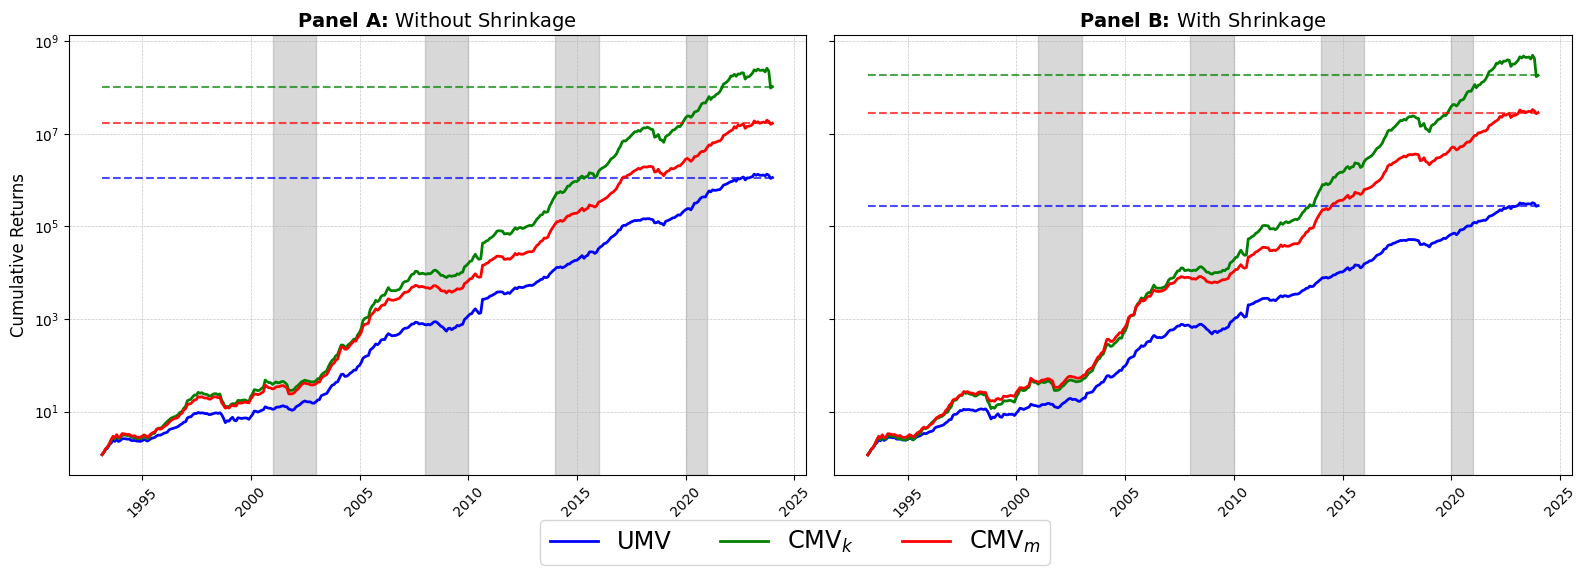

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Define Norwegian recessions as a list of tuples with start and end dates
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31')   # COVID-19 pandemic
]

# Panel A: Without Shrinkage
lines_a = {
    'UMV': (1 + MV['UMV']).cumprod(),
    'CMV_k': (1 + MV['CMV_k']).cumprod(),
    'CMV_m': (1 + MV['CMV_m']).cumprod()
}
colors_a = {'UMV': 'blue', 'CMV_k': 'green', 'CMV_m': 'red'}

for label, data in lines_a.items():
    axes[0].plot(data, color=colors_a[label], label=label, linewidth=2)
    axes[0].hlines(data.iloc[-1], xmin=data.index[0], xmax=data.index[-1], colors=colors_a[label], linestyles='dashed', alpha=0.7)

axes[0].set_title(r'Panel A: $\text{Without Shrinkage}$', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Returns', fontsize=12)
axes[0].set_yscale('log')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding recession shading to Panel A
for start, end in recessions:
    axes[0].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Panel B: With Shrinkage
lines_b = {
    'UMV^s': (1 + MV['UMV^s']).cumprod(),
    'CMV_k^s': (1 + MV['CMV_k^s']).cumprod(),
    'CMV_m^s': (1 + MV['CMV_m^s']).cumprod()
}
colors_b = {'UMV^s': 'blue', 'CMV_k^s': 'green', 'CMV_m^s': 'red'}

for label, data in lines_b.items():
    axes[1].plot(data, color=colors_b[label], label=label, linewidth=2)
    axes[1].hlines(data.iloc[-1], xmin=data.index[0], xmax=data.index[-1], colors=colors_b[label], linestyles='dashed', alpha=0.7)

axes[1].set_title(r'Panel B: $\text{With Shrinkage}$', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding recession shading to Panel B
for start, end in recessions:
    axes[1].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Adding a single legend closer to the plots
handles = axes[0].get_legend_handles_labels()[0]
labels = ['UMV', r'CMV$_k$', r'CMV$_m$']
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.030), ncol=3, fontsize='xx-large')

# Format x-axis with better date formatting
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.tick_params(axis='x', rotation=45)


# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('Plots/3-cumulative_returns_MV.png', dpi=300, bbox_inches='tight')
plt.show()

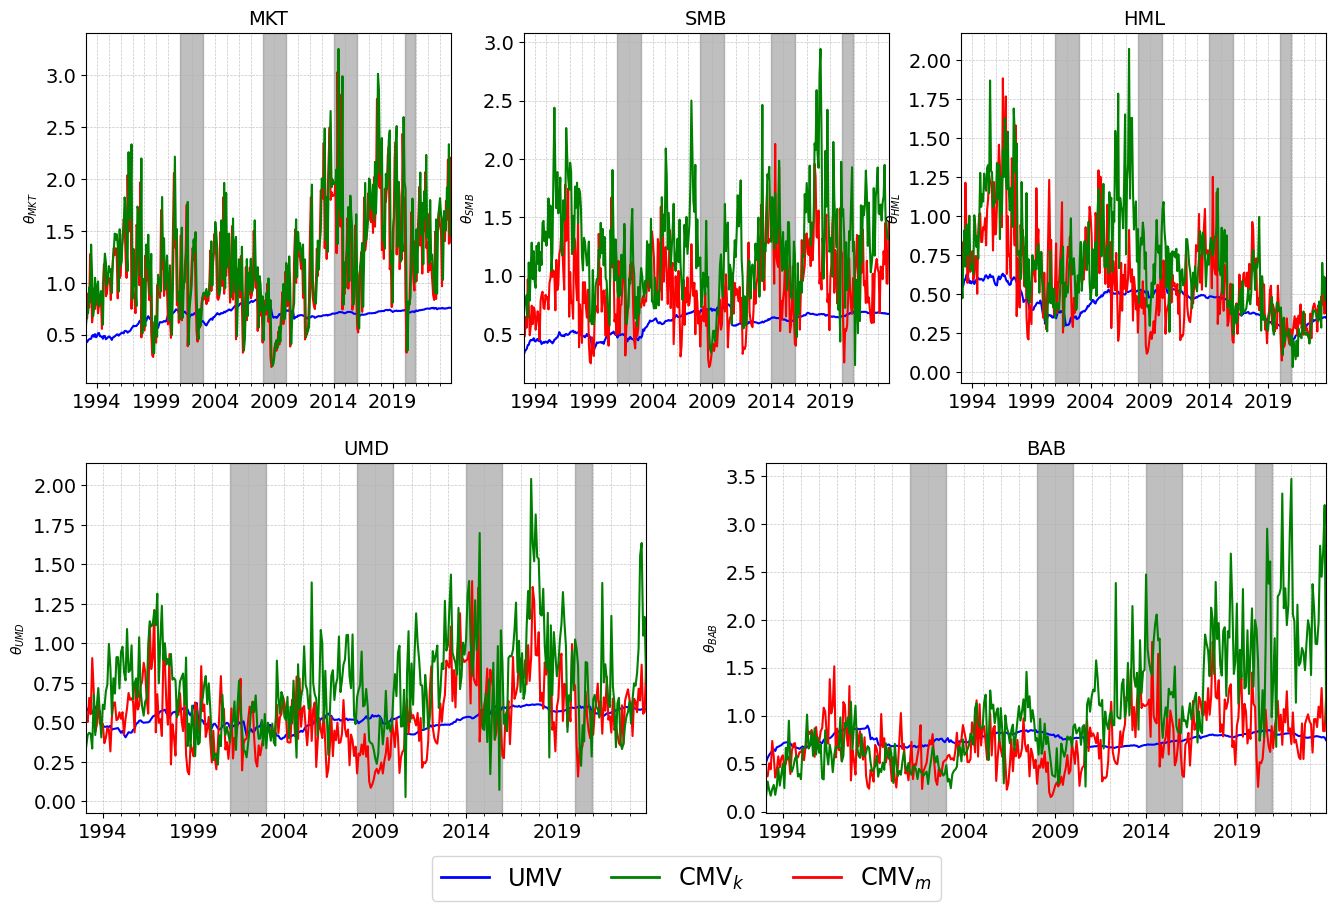

In [9]:
### Plotting the loadings
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs = axs.ravel()

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Iterate over the factors and plot
for i, factor in enumerate(loading_umv.columns):
    if factor == 'BAB':
        i += 1
    loading_umv_s[factor].plot(ax=axs[i], title=factor, color='blue', label='UMV', fontsize=14)
    loading_cmv_m_s[factor].plot(ax=axs[i], title=factor, color='red', label=r'CMV$_m$', fontsize=14)
    loading_cmv_k_s[factor].plot(ax=axs[i], title=factor, color='green', label=r'CMV$_k$', fontsize=14)

    # Add grey fields for recessions
    for start, end in recessions:
        axs[i].axvspan(start, end, color='grey', alpha=0.5)

    # Remove the x-axis label
    axs[i].set_xlabel('')

    # Set the y-axis label
    axs[i].set_ylabel(rf'$\theta_{{{factor}}}$')

    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axs[i].set_title(factor, fontsize=14)


# Adding a legend under the entire plot, showing labels only from the first subplot
handles = axes[0].get_legend_handles_labels()[0]
labels = ['UMV', r'CMV$_k$', r'CMV$_m$']
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=3, fontsize='xx-large')

# Remove the last empty subplot
fig.delaxes(axs[-2])

# Center the last two plots
axs[-1].set_position([0.55, 0.1, 0.35, 0.35])  # Adjust position for the second-to-last plot
axs[-3].set_position([0.125, 0.1, 0.35, 0.35])  # Adjust position for the last plot
plt.savefig('Plots/4-weights_of_ptf.png', dpi=300, bbox_inches='tight')
plt.show()

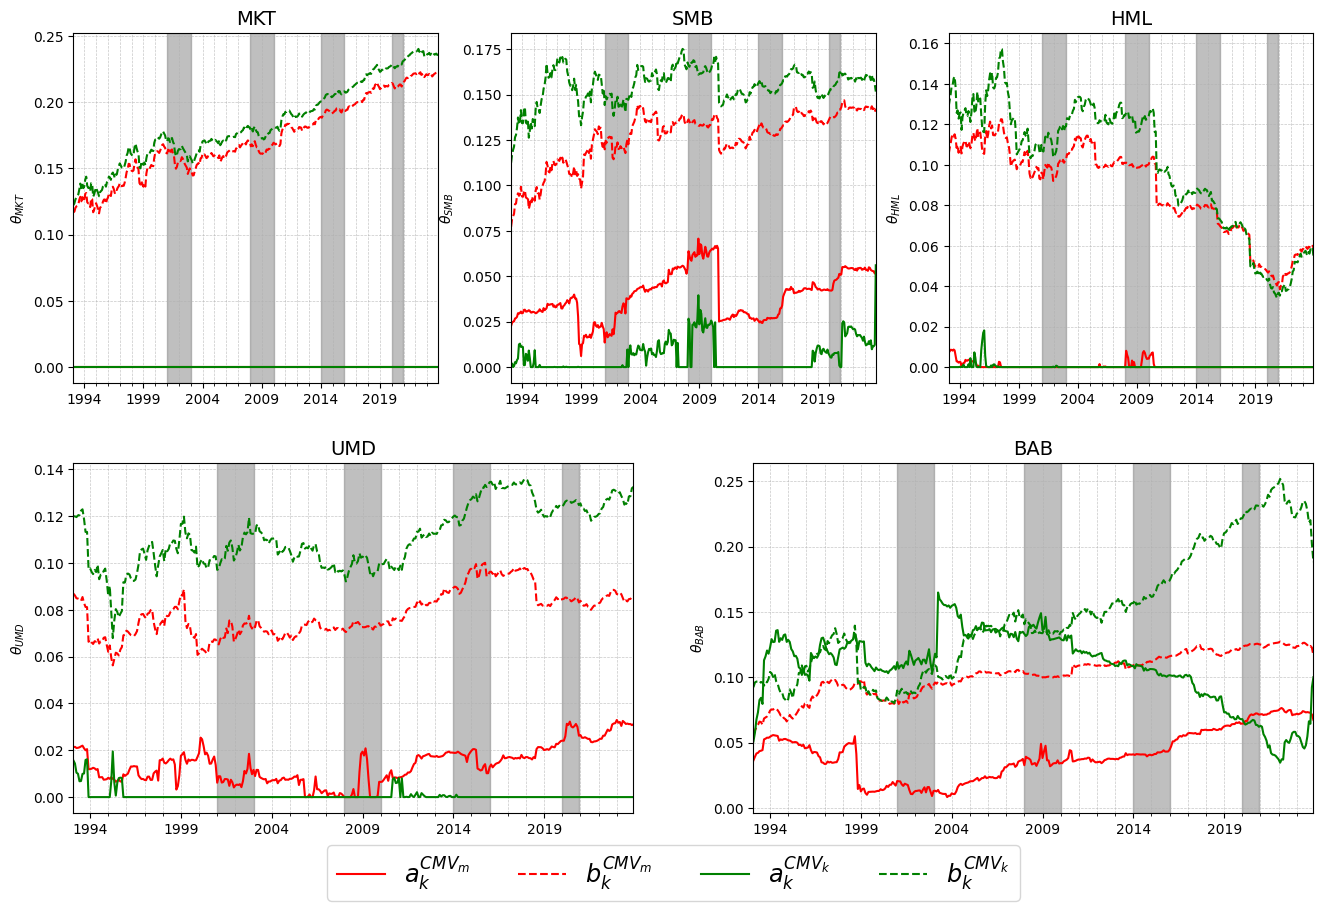

In [10]:
### Plotting the loadings
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs = axs.ravel()

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Iterate over the factors and plot
for i, factor in enumerate(a_cmv_m.columns):
    if factor == 'BAB':
        i += 1
    a_cmv_m_s[factor].plot(ax=axs[i], title=factor, color='red', label=r'$a_k^{CMV_{m}}$')
    b_cmv_m_s[factor].plot(ax=axs[i], title=factor, color='red', label=r'$b_k^{CMV_{m}}$', linestyle='dashed')
    a_cmv_k_s[factor].plot(ax=axs[i], title=factor, color='green', label=r'$a_k^{CMV_{k}}$')
    b_cmv_k_s[factor].plot(ax=axs[i], title=factor, color='green', label=r'$b_k^{CMV_{k}}$', linestyle='dashed')

    # Add grey fields for recessions
    for start, end in recessions:
        axs[i].axvspan(start, end, color='grey', alpha=0.5)

    # Remove the x-axis label
    axs[i].set_xlabel('')

    # Set the y-axis label
    axs[i].set_ylabel(rf'$\theta_{{{factor}}}$')

    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axs[i].set_title(factor, fontsize=14)


# Adding a legend under the entire plot, showing labels only from the first subplot
handles = axs[0].get_legend_handles_labels()[0]
labels = [r'$a_k^{CMV_{m}}$', r'$b_k^{CMV_{m}}$', r'$a_k^{CMV_{k}}$', r'$b_k^{CMV_{k}}$']
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=4, fontsize='xx-large')

# Remove the last empty subplot
fig.delaxes(axs[-2])

# Center the last two plots
axs[-1].set_position([0.55, 0.1, 0.35, 0.35])  # Adjust position for the second-to-last plot
axs[-3].set_position([0.125, 0.1, 0.35, 0.35])  # Adjust position for the last plot
plt.savefig('Plots/5-a_and_b.png', dpi=300, bbox_inches='tight')
plt.show()

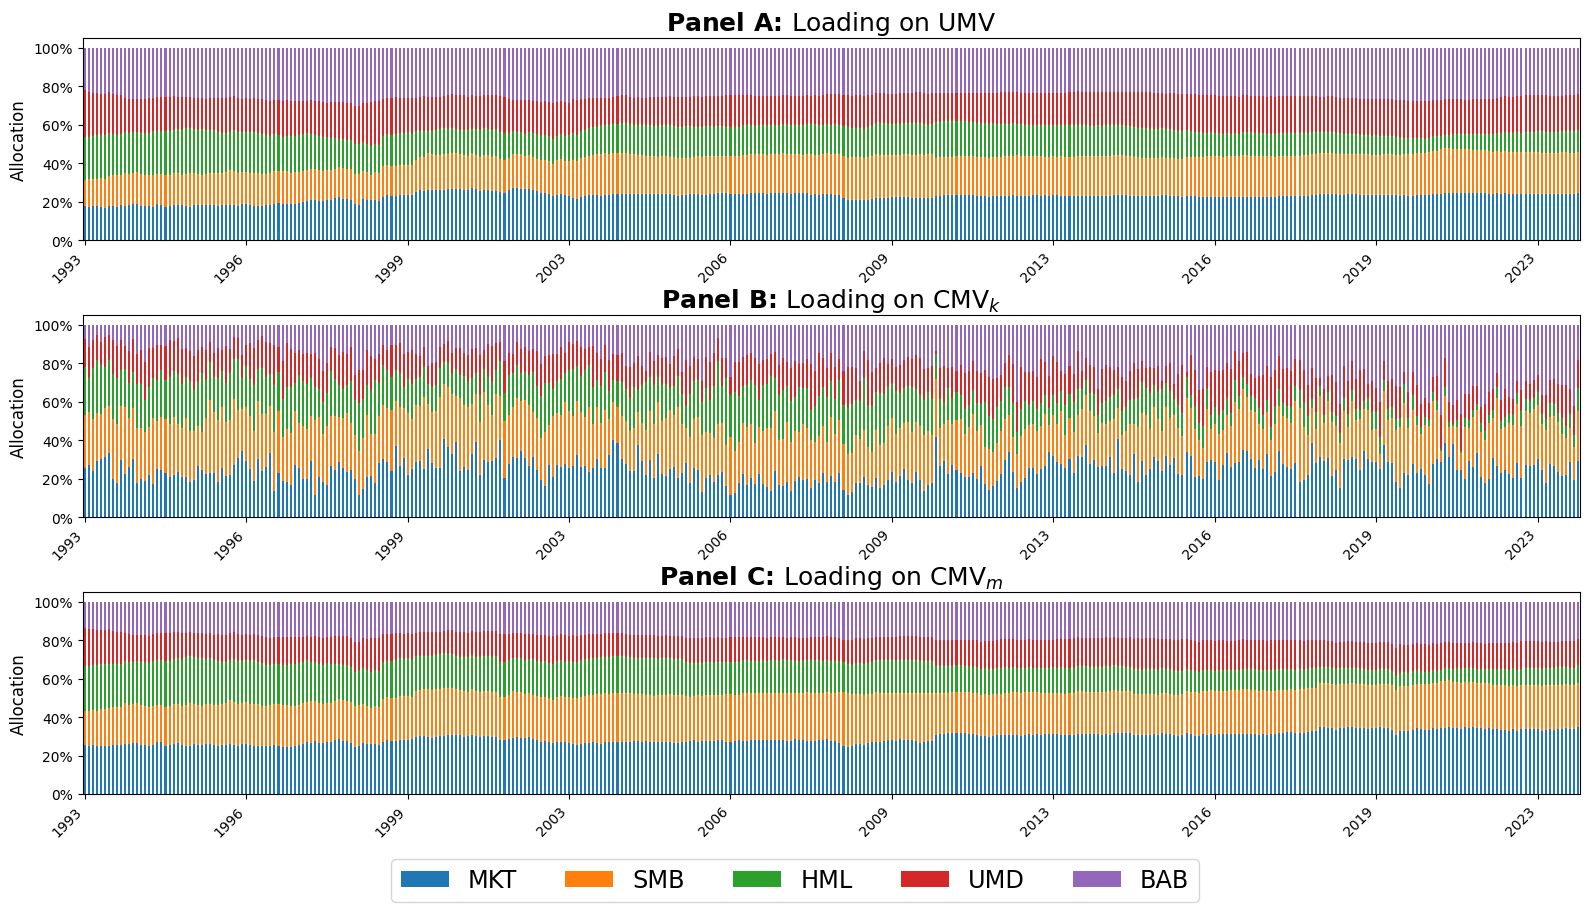

In [11]:


### Getting the loadings in %
loading_umv_s_percent = loading_umv_s.apply(lambda x: x / x.sum(), axis=1)
loading_cmv_m_s_percent = loading_cmv_m_s.apply(lambda x: x / x.sum(), axis=1)
loading_cmv_k_s_percent = loading_cmv_k_s.apply(lambda x: x / x.sum(), axis=1)
loading_umv_s_percent.index = MV.index
loading_cmv_m_s_percent.index = MV.index
loading_cmv_k_s_percent.index = MV.index

# Plotting bar plots for each of the loading percentages
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=False)

# Define colors for the columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot for loading_umv_s_percent
loading_umv_s_percent.plot(kind='bar', stacked=True, ax=axes[0], color=colors, legend=False)
axes[0].set_title(r'Panel A: $\text{Loading on UMV}$', fontsize=18, fontweight='bold')
axes[0].set_ylabel('Allocation', fontsize=12)
axes[0].yaxis.set_major_formatter(PercentFormatter(1))

# Plot for loading_cmv_k_s_percent
loading_cmv_k_s_percent.plot(kind='bar', stacked=True, ax=axes[1], color=colors, legend=False)
axes[1].set_title(r'Panel B: $\text{Loading on CMV}_k$', fontsize=18, fontweight='bold')
axes[1].set_ylabel('Allocation', fontsize=12)
axes[1].yaxis.set_major_formatter(PercentFormatter(1))

# Plot for loading_cmv_m_s_percent
loading_cmv_m_s_percent.plot(kind='bar', stacked=True, ax=axes[2], color=colors, legend=False)
axes[2].set_title(r'Panel C: $\text{Loading on CMV}_m$', fontsize=18, fontweight='bold')
axes[2].set_ylabel('Allocation', fontsize=12)
axes[2].yaxis.set_major_formatter(PercentFormatter(1))

# Add recession shading to all subplots
for ax in axes:
    ax.set_xticks(range(len(MV.index)))
    ax.set_xticklabels(MV.index.strftime('%Y'), rotation=45, ha='right')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=12)) 
    ax.set_xlabel('')

# Adding a single legend for all plots
fig.legend(loading_umv_s_percent.columns, loc='lower center', bbox_to_anchor=(0.5, 0.08), ncol=5, fontsize='xx-large')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('Plots/6-weight_allocation_of_ptf.png', dpi=300)
plt.show()

In [12]:
### Getting the p-value between UMV without shrinkage and CMV_m with shrinkage
diff = []

for i in range(n_boot):
    boot = stationary_bootstrap(np.array(MV.iloc[:, [0, 5]].astype(float)), 5, len(MV))
    diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

extra_p_value = (np.sum(np.array(diff) > 0) / (len(diff)))

print(f'The p-value between UMV without shrinkage and CMV_m with shrinkage is: {extra_p_value:.4f}')

The p-value between UMV without shrinkage and CMV_m with shrinkage is: 0.1155


In [13]:
### Saving the data
conn = sqlite3.connect('Data/data.db')
MV.to_sql('MV', conn, if_exists='replace')
conn.close()